In [1]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [2]:
# Check if the GPU is available
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is not available


In [3]:
# Directory where the images are stored
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'

In [4]:
# Function for uploading and resizing images
def load_image(image_path, target_size=(112, 112)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  
        return np.array(image) / 255.0  
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [5]:
# Load training group IDs
train_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\vague_train.txt'
with open(train_ids_file, 'r') as file:
    train_ids = [str(id) for id in json.loads(file.read())]

In [6]:
# Load validation group IDs
val_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\vague_val.txt'
with open(val_ids_file, 'r') as file:
    val_ids = [str(id) for id in json.loads(file.read())]

In [7]:
%%capture
# Lists for storing image paths and corresponding labels
train_data = []
val_data = []

# Iterate over all the files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Erro ao carregar JSON {json_path}: {e}")
                continue
        
        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"ID da amostra ausente no JSON: {json_path}")
            continue

        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Arquivo de imagem não encontrado: {image_path}")
            continue
        
        classes = json_data.get('classes', [])
        if not classes:
            print(f"Chave 'classes' ausente ou vazia no JSON: {json_path}")
            continue
        
        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [8]:
# Check the number of images uploaded
print(f"Número de imagens de treinamento carregadas: {len(train_data)}")
print(f"Número de imagens de validação carregadas: {len(val_data)}")

Número de imagens de treinamento carregadas: 642
Número de imagens de validação carregadas: 214


In [9]:
# Separate images and labels
train_images = [data[0] for data in train_data]
train_labels = [data[1] for data in train_data]

In [10]:
val_images = [data[0] for data in val_data]
val_labels = [data[1] for data in val_data]

In [11]:
# Load the images
train_images = [load_image(image_path, target_size=(112, 112)) for image_path in train_images]
val_images = [load_image(image_path, target_size=(112, 112)) for image_path in val_images]

In [12]:
# Check if an image has failed to load
train_images = [img for img in train_images if img is not None]
val_images = [img for img in val_images if img is not None]

In [13]:
# Convert the labels to the appropriate format (numeric)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Use sparse_output instead of sparse
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Adjust the encoder on the training labels and turn them into one-hot encoding
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))

# Transform validation labels
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

In [15]:
# Load the ResNet50 base model with pre-trained weights from ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

In [16]:
# Freeze ResNet50 layers to train only customised layers
base_model.trainable = False

In [17]:
# Add new layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [18]:
# create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
# Fine-tuning 
# Defrost the last layers of ResNet50 for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [20]:
# recompile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [21]:
# train the model
history_finetune = model.fit(
    np.array(train_images), 
    train_labels_one_hot, 
    epochs=20, 
    batch_size=32, 
    validation_data=(np.array(val_images), val_labels_one_hot)
)

Epoch 1/20
21/21 [==============================] - 28s 1s/step - loss: 1.0284 - accuracy: 0.5732 - val_loss: 1.3106 - val_accuracy: 0.0935
Epoch 2/20
21/21 [==============================] - 22s 1s/step - loss: 0.7899 - accuracy: 0.6791 - val_loss: 1.2009 - val_accuracy: 0.0935
Epoch 3/20
21/21 [==============================] - 22s 1s/step - loss: 0.6918 - accuracy: 0.7368 - val_loss: 1.1685 - val_accuracy: 0.4206
Epoch 4/20
21/21 [==============================] - 22s 1s/step - loss: 0.6715 - accuracy: 0.7570 - val_loss: 1.1364 - val_accuracy: 0.4299
Epoch 5/20
21/21 [==============================] - 23s 1s/step - loss: 0.6961 - accuracy: 0.7523 - val_loss: 1.1073 - val_accuracy: 0.4019
Epoch 6/20
21/21 [==============================] - 22s 1s/step - loss: 0.6887 - accuracy: 0.7461 - val_loss: 1.0738 - val_accuracy: 0.4346
Epoch 7/20
21/21 [==============================] - 23s 1s/step - loss: 0.7374 - accuracy: 0.7165 - val_loss: 1.0199 - val_accuracy: 0.4439
Epoch 8/20
21/21 [==

In [22]:
#save the model
model.save('trained_model.resnet_vague_resolution')

INFO:tensorflow:Assets written to: trained_model.resnet_vague_resolution\assets


INFO:tensorflow:Assets written to: trained_model.resnet_vague_resolution\assets


In [23]:
# Evaluate in the validation set
val_loss, val_accuracy = model.evaluate(np.array(val_images), val_labels_one_hot)
print(f"Loss no conjunto de validação: {val_loss}")
print(f"Accuracy no conjunto de validação: {val_accuracy}")

7/7 [==============================] - 4s 608ms/step - loss: 0.5847 - accuracy: 0.8037
Loss no conjunto de validação: 0.5846870541572571
Accuracy no conjunto de validação: 0.8037382960319519


In [41]:
target_names = ['Classe_0', 'Classe_1', 'Classe_2']

In [24]:
# Check the classes in the data
print(f"Classes reais: {label_encoder.classes_}")

# Adjust target_names as necessary
target_names = label_encoder.classes_

Classes reais: ['E.coli' 'P.aeruginosa' 'S.aureus']


In [25]:
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions from the model
val_predictions = model.predict(np.array(val_images))

# Convert one-hot encoded predictions to labels
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)
print("Matriz de Confusão:")
print(conf_matrix)

# Check the classes in the data
print(f"Classes reais: {label_encoder.classes_}")

# Adjust target_names as necessary
target_names = label_encoder.classes_

# Classification report
class_report = classification_report(val_labels_labels, val_predictions_labels, target_names=target_names)
print("Relatório de Classificação:")
print(class_report)

7/7 [==============================] - 5s 574ms/step
Matriz de Confusão:
[[91 10  0]
 [12 81  0]
 [ 7 13  0]]
Classes reais: ['E.coli' 'P.aeruginosa' 'S.aureus']
Relatório de Classificação:
              precision    recall  f1-score   support

      E.coli       0.83      0.90      0.86       101
P.aeruginosa       0.78      0.87      0.82        93
    S.aureus       0.00      0.00      0.00        20

    accuracy                           0.80       214
   macro avg       0.54      0.59      0.56       214
weighted avg       0.73      0.80      0.76       214



C:\Users\bruna\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bruna\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bruna\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# Save the confusion matrix and the classification report
np.save('confusion_matrix.npy', conf_matrix)

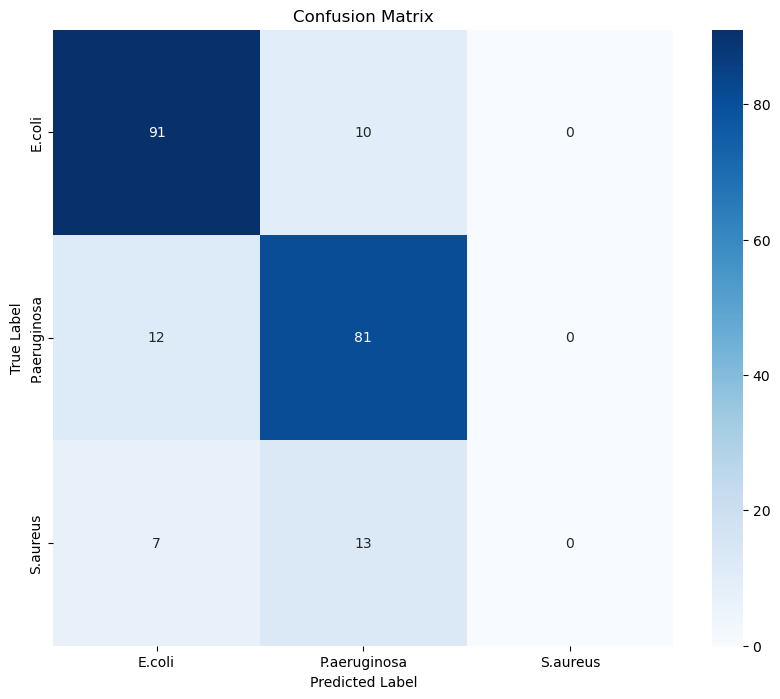

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualise the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtain the model's predictions (probabilities) for the validation set
val_predictions_prob = model.predict(np.array(val_images))

7/7 [==============================] - 5s 677ms/step


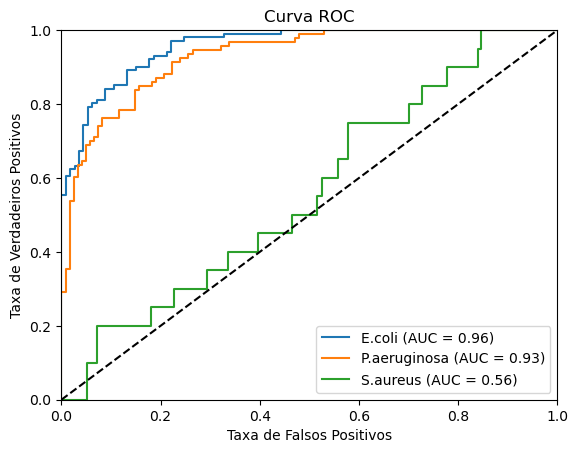

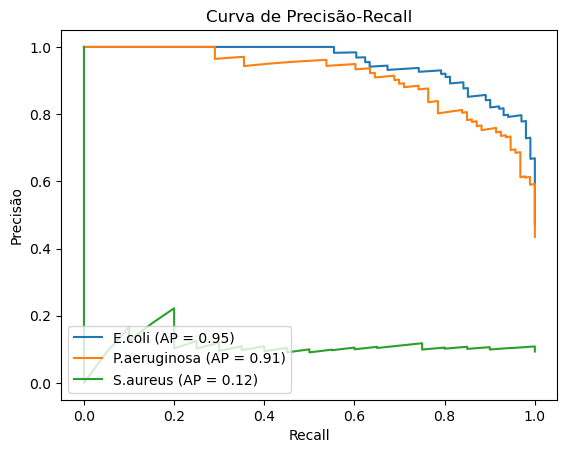

In [29]:
# Calculate the ROC curve and the area under the curve (AUC) for each class
fpr = {}
tpr = {}
roc_auc = {}

# Para cada classe, calcular os valores de FPR e TPR
for i in range(len(target_names)):
    fpr[i], tpr[i], _ = roc_curve(val_labels_one_hot[:, i], val_predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure()
for i in range(len(target_names)):
    plt.plot(fpr[i], tpr[i], label=f'{target_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Calculate the precision-recall curve (PRC) and the area under the precision curve (AP)
precision = {}
recall = {}
average_precision = {}

for i in range(len(target_names)):
    precision[i], recall[i], _ = precision_recall_curve(val_labels_one_hot[:, i], val_predictions_prob[:, i])
    average_precision[i] = average_precision_score(val_labels_one_hot[:, i], val_predictions_prob[:, i])

# Plot the precision-recall curve
plt.figure()
for i in range(len(target_names)):
    plt.plot(recall[i], precision[i], label=f'{target_names[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva de Precisão-Recall')
plt.legend(loc='lower left')
plt.show()